# AML Dataset

In [ ]:
%%capture
!pip install category_encoders==2.*

In [ ]:
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, validation_curve # k-fold CV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV # Hyperparameter tuning
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier 
from category_encoders import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, plot_confusion_matrix

In [ ]:
filepath = 'aml_ohsu_2018_clinical_data.tsv'

def wrangle(filepath):

  df = pd.read_csv("/content/aml_ohsu_2018_clinical_data.tsv", sep = '\t')

  #drop constant columns - I know all of these people have Leukemia
  df.drop(columns = ['Cancer Type'], inplace= True)
  df.drop(columns = ['Study ID'], inplace = True)

  #dropping HCC
  cutoff = 100
  drop_cols = [col for col in df.select_dtypes('object').columns
               if df[col].nunique() > cutoff]
  df.drop(columns= drop_cols, inplace=True)

  #columns to drop that we wont be using in our prediction
  df.drop(columns = ['Age At Procurement', 'BRAF mutation', 'Diagnosis', 
                     'Diagnosis at Inclusion', 'ELN 2008 Risk Classification', 
                     'Group', 'Negative for FLT3', 'Fusion', 'Group', 
                     'Response to Induction Treatment', 'Oncotree Code',
                     'Platform', 'Site of Sample', 'Sample Timepoint', 'Somatic Status',
                     'Specific Diagnosis at Acquisition', 'Specific Diagnosis at Inclusion'],
          inplace = True)

  #leaky data - seeing treatment regimen counts and type of treatment
  #received tells us how sick someone likely is
  
  df.drop(columns = ['Chemotherapy', 'Cumulative Treatment Regimen Count', 'Cumulative Treatment Types', 
                     'Cumulative Treatment Type Count', 'Current Stage', 
                     'Duration of Induction Treatment', 'Most Recent Treatment Duration', 
                     'Most Recent Treatment Type', 'Cause of death source', 'Treatment Type', 
                     'Type of Induction Treatment', 'ELN 2017 Risk Classification',
                     'Overall Survival (Months)'], inplace = True)
  
  df.drop(columns = ['CEBPA Mutation','Sample collection center', 'DNMT3A Mutation', 
                     'IDH1 Mutation', 'IDH2 Negative', 'NRAS Mutation', 'Immature Granulocytes Percent in Peripheral Blood',
                     'Nucleated RBCs Percent in Peripheral Blood', 'TP53 Mutation',
                     'Prior Diagnosis of Cancer', 'Prior Malignancy Radiation Therapy'], inplace = True)
  
  df = df.dropna(subset=['Overall Survival Status'])

  

  object_cols = [col for col in df.select_dtypes('object').columns]
  df[object_cols] = df[object_cols].astype(str)

  return df

df = wrangle(filepath)

df['Overall Survival Status'].value_counts(normalize = True)

1:DECEASED    0.584843
0:LIVING      0.415157
Name: Overall Survival Status, dtype: float64

In [ ]:
# Determining my feature matrix X and Target Vector Y

X = df.drop(columns = 'Overall Survival Status')
y = df['Overall Survival Status']
y.shape
df['Overall Survival Status'].value_counts()

1:DECEASED    355
0:LIVING      252
Name: Overall Survival Status, dtype: int64

In [ ]:
# Splitting into training and validation sets

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.80, test_size=0.20, random_state=42)
y_train.head()

9      1:DECEASED
242    1:DECEASED
653    1:DECEASED
568      0:LIVING
138      0:LIVING
Name: Overall Survival Status, dtype: object

In [ ]:
# baseline accuracy
y_train.value_counts(normalize=True).max()

0.5855670103092784

In [ ]:
# XGBoost model
model_xgb = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    XGBClassifier(random_state=42, n_estimators = 50))

model_xgb.fit(X_train,y_train);

In [ ]:
# show me the money
print('Training Accuracy', model_xgb.score(X_train, y_train))
print('Validation Accuracy', model_xgb.score(X_val, y_val))

Training Accuracy 0.8742268041237113
Validation Accuracy 0.639344262295082


In [ ]:
#lets make some decisions with some trees
model_dc = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    DecisionTreeClassifier(random_state=42,max_depth=5))

model_dc.fit(X_train,y_train);

In [ ]:
print('Training Accuracy', model_dc.score(X_train, y_train))
print('Validation Accuracy', model_dc.score(X_val, y_val))

Training Accuracy 0.777319587628866
Validation Accuracy 0.6557377049180327


In [ ]:
# logistic regressionnnnn
model_lr = make_pipeline(
    OneHotEncoder(use_cat_names=True), 
    SimpleImputer(strategy='mean'), 
    StandardScaler(), 
    LogisticRegression()
)

model_lr.fit(X_train, y_train);

print('Training Accuracy', model_lr.score(X_train, y_train))
print('Validation Accuracy', model_lr.score(X_val, y_val))

Training Accuracy 0.7938144329896907
Validation Accuracy 0.7540983606557377


In [ ]:
#random forest
model_rf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(n_estimators = 25, max_depth = 5, max_features = 18, random_state=42, n_jobs=-1))

model_rf.fit(X_train, y_train);


In [ ]:
print('Training Accuracy', model_rf.score(X_train, y_train))
print('Validation Accuracy', model_rf.score(X_val, y_val))

Training Accuracy 0.8494845360824742
Validation Accuracy 0.639344262295082


              precision    recall  f1-score   support

    0:LIVING       0.77      0.59      0.67        51
  1:DECEASED       0.75      0.87      0.81        71

    accuracy                           0.75       122
   macro avg       0.76      0.73      0.74       122
weighted avg       0.76      0.75      0.75       122



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


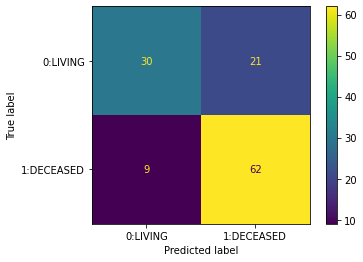

In [ ]:
#confusion matrix for logistic regression

print(classification_report(y_val, model_lr.predict(X_val)))
plot_confusion_matrix(model_lr, X_val, y_val)

In [ ]:
cv_scores_dc = cross_val_score(model_dc, X, y, cv=5,n_jobs=-1)
cv_scores_rf = cross_val_score(model_rf, X, y, cv=5,n_jobs=-1)

In [ ]:
print('CV score DecisionTreeClassifier')
print(cv_scores_dc) 
print('Mean CV accuracy score:', cv_scores_dc.mean())
print('STD CV accuracy score:', cv_scores_dc.std())

CV score DecisionTreeClassifier
[0.6147541  0.69672131 0.66115702 0.59504132 0.56198347]
Mean CV accuracy score: 0.6259314456035767
STD CV accuracy score: 0.0477923064813315
